In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import norm
import scipy as sp
import random
from src.functions import * 

# Set some defaults
plt.rc("axes.spines", top=False, right=False)

sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")

# Import python library/function for function optimization
import scipy.optimize

%config InlineBackend.figure_format = "retina"

## The Plan

### Parameter and model recovery (Can I do both at same time?)
1) Simulate data using best-fit parameters from each model (or samples from within the range of best-fits). For example, 100 simulations of each model within range of best-fit parameters.
2) Re-estimate parameters.
3) Model comparison with AIC/BIC. 
4) Correlate parameters used for simulation with recovered parameters.


In [2]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")

# Read in csv with MLEs from all models
# Need a function to convert string back to numpy array
def converter(input_str):
    return np.fromstring(input_str[1:-1], sep=' ')

fits = pd.read_csv("../results/params_mle_reducedmodels.csv", converters={"theta":converter})
fits.head()

,subj_num,model,theta,loglik,bic,delta_bic
0,1,pea,"[9.34023228, 0.36206566, 1.29827665]",-2650.946357,5323.229696,-209.503440
1,1,premo,"[0.843862233, 16.7663819, 0.01, 25.0, 1.0, 1.0...",-2745.029585,5532.733135,0.000000
2,1,rem,"[14.2432723, 3.81197959, 9.99980445, 1.29836274]",-2650.973430,5330.396170,-202.336966
3,1,piece,"[5.95716432, 0.01, 1.01037002]",-2526.204156,5073.745295,-458.987840
4,2,pea,"[3.76251428, 0.49892211, 0.89640008]",-2854.631264,5730.599509,-186.281992


In [3]:
# Lambda functions for computing negative log-likelihoods
nll_pea = lambda x: negloglik(model="pea", sigma_int=x[0], B=x[1], bias=x[2], 
                                   sigma_motor=motor_sd, num_trials=num_trials, 
                                   vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
nll_premo = lambda x: negloglik(model="premo", B=x[0], sigma_pred=x[1], 
                                     sigma_v=x[2], sigma_p=x[3], eta_p=x[4], bias=x[5], 
                                     sigma_motor=motor_sd, num_trials=num_trials, 
                                     vis_fb=vis_fb, rotation=rotation, 
                                     x_hand=x_hand)
nll_piece = lambda x: negloglik(model="piece", sigma_pert=x[0], sigma_comb=x[1], 
                                     bias = x[2], sigma_motor=motor_sd, num_trials=num_trials, 
                                     vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
nll_rem = lambda x: negloglik(model="rem", sigma_comb=x[0], s=x[1], c=x[2], bias=x[3],
                                   sigma_motor=motor_sd, num_trials=num_trials, 
                                   vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)

---
## Model recovery analysis (i.e., build confusion matrix)

In [4]:
%%time

models = ["piece", "pea", "premo", "rem"]
simulated_params = []
recovered_params = []
model = []
winner_bic = []
winner_aic = []
iteration = []

# Group by model and stack params into 2d array
params = fits.groupby("model")["theta"].apply(np.stack)
params_piece = params["piece"]
params_pea = params["pea"]
params_premo = params["premo"]
params_rem = params["rem"]

# Set upper and lower bounds on simulated params
piece_lb = params_piece.min(axis=0)
piece_ub = params_piece.max(axis=0)
pea_lb = params_pea.min(axis=0)
pea_ub = params_pea.max(axis=0)
premo_lb = params_premo.min(axis=0)
premo_ub = params_premo.max(axis=0)
rem_lb = params_rem.min(axis=0)
rem_ub = params_rem.max(axis=0)

# Pull out experimental parameters (same for all 16 subjects)
rotation = df.loc[df["SN"] == 1, "rotation"].values
vis_fb = df.loc[df["SN"] == 1, "fbi"].values
num_trials = len(np.unique(df["TN"]))

# Determine how many simulations to run
n_sims = 10

# Model recovery analysis
for i in range(n_sims):
    print(i)
    
    # Sample from range of reasonable values
    motor_sd_lb = df["motor_sd"].min()
    motor_sd_ub = df["motor_sd"].max()
    motor_sd = np.random.uniform(low=motor_sd_lb, high=motor_sd_ub)
    
    # Generate parameter values for each model through random sampling
    piece_simparams = np.random.uniform(low=piece_lb, high=piece_ub)
    pea_simparams = np.random.uniform(low=pea_lb, high=pea_ub)
    premo_simparams = np.random.uniform(low=premo_lb, high=premo_ub)
    rem_simparams = np.random.uniform(low=rem_lb, high=rem_ub)

    # Loop through models
    for j in range(len(models)):
        if j == 0:
            # Simulate with best-fit parameters
            # PIECE model
            _, xhat = piece(
                piece_simparams[0], 
                piece_simparams[1], 
                piece_simparams[2], 
                motor_sd, len(rotation), 
                vis_fb, 
                rotation,
                fit=False
            )
            simulated_model = "piece"
            simulated_params.append(piece_simparams)
        elif j == 1:
            # PEA model
            _, xhat = pea(
                pea_simparams[0], 
                pea_simparams[1],
                pea_simparams[2], 
                motor_sd, len(rotation), 
                vis_fb, 
                rotation,
                fit=False
            )
            simulated_model = "pea"
            simulated_params.append(pea_simparams)
        elif j == 2:
            # PReMo 
            _, xhat = premo(
                premo_simparams[0],
                premo_simparams[1],
                premo_simparams[2], 
                premo_simparams[3],
                premo_simparams[4],
                premo_simparams[5],
                motor_sd, len(rotation), 
                vis_fb, 
                rotation,
                fit=False
            )
            simulated_model = "premo"
            simulated_params.append(premo_simparams)
        elif j == 3:
            # REM
            _, xhat = rem(
                rem_simparams[0],
                rem_simparams[1],
                rem_simparams[2], 
                rem_simparams[3], 
                motor_sd, len(rotation), 
                vis_fb, 
                rotation,
                fit=False
            )
            simulated_model = "rem"
            simulated_params.append(rem_simparams)
            
        # Assign simulated hand position to correct var name
        x_hand = xhat
        
        # Fit simulated data
        # PIECE model params: sigma_pert, sigma_comb, bias
        bounds = ((0.01, 30), (0.01, 25), (-5, 5))
        piece_results = scipy.optimize.minimize(
            fun=nll_piece, 
            bounds=bounds,
            x0 = np.array([4.97, 0.71, 0.58])  # middle of simulated param vals
        )
        aic_piece = calc_aic(piece_results.fun * -1, len(piece_results.x))
        bic_piece = calc_bic(piece_results.fun * -1, len(piece_results.x), len(rotation))
        if simulated_model == "piece":
            recovered_params.append(piece_results.x)
        
        # PEA model params: sigma_comb, B, bias
        bounds = ((0.01, 25), (0, 1), (-5, 5))
        pea_results = scipy.optimize.minimize(
            fun=nll_pea, 
            bounds=bounds,
            # x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
            #              np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
            #              np.random.uniform(low=bounds[2][0], high=bounds[2][1])])
            x0 = np.array([13.52, 0.31, 0.63])
        )
        aic_pea = calc_aic(pea_results.fun * -1, len(pea_results.x))
        bic_pea = calc_bic(pea_results.fun * -1, len(pea_results.x), len(rotation))
        if simulated_model == "pea":
            recovered_params.append(pea_results.x)
        
        # PReMo model params: B, sigma_v, sigma_p, sigma_pred, eta_p, bias
        bounds = ((0, 1), (0.01, 25), (0.01, 25), (0.01, 25), (0, 1), (-5, 5))
        premo_results = scipy.optimize.minimize(
            fun=nll_premo,  
            bounds=bounds,
            # x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
            #              np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
            #              np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
            #              np.random.uniform(low=bounds[3][0], high=bounds[3][1]),
            #              np.random.uniform(low=bounds[4][0], high=bounds[4][1]),
            #              np.random.uniform(low=bounds[5][0], high=bounds[5][1])])
            x0 = np.array([0.52, 12.51, 12.51, 12.52, 1., 0.58])
        )
        aic_premo = calc_aic(premo_results.fun * -1, len(premo_results.x))
        bic_premo = calc_bic(premo_results.fun * -1, len(premo_results.x), len(rotation))
        if simulated_model == "premo":
            recovered_params.append(premo_results.x)
        
        # REM model params: sigma_comb, s, c, bias
        bounds = ((0.01, 25), (0, 10), (0, 10), (-5, 5))
        rem_results = scipy.optimize.minimize(
            fun=nll_rem, 
            bounds=bounds,
            # x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
            #              np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
            #              np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
            #              np.random.uniform(low=bounds[3][0], high=bounds[3][1])])
            x0 = np.array([13.47, 2.13, 5.00, 0.64])
        )
        aic_rem = calc_aic(rem_results.fun * -1, len(rem_results.x))
        bic_rem = calc_bic(rem_results.fun * -1, len(rem_results.x), len(rotation))
        if simulated_model == "rem":
            recovered_params.append(rem_results.x)
        
        # Store winning model
        winner_aic.append(models[np.argmin([aic_piece, aic_pea, aic_premo, aic_rem])])
        winner_bic.append(models[np.argmin([bic_piece, bic_pea, bic_premo, bic_rem])])

        # Update variables
        model.append(simulated_model)
        iteration.append(i)

# Store variables in data frame
df_model = pd.DataFrame({
    "iteration": iteration,
    "model":model, 
    "winner_aic":winner_aic, 
    "winner_bic":winner_bic,
    "simulated_params": simulated_params,
    "recovered_params": recovered_params
})

0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1
2
3
4
5
6
7
8
9
CPU times: user 52min 29s, sys: 1.85 s, total: 52min 31s
Wall time: 52min 52s


In [ ]:
# # SAVE DATA FRAME
# df_model.to_csv("../results/model_recovery.csv", index=False)


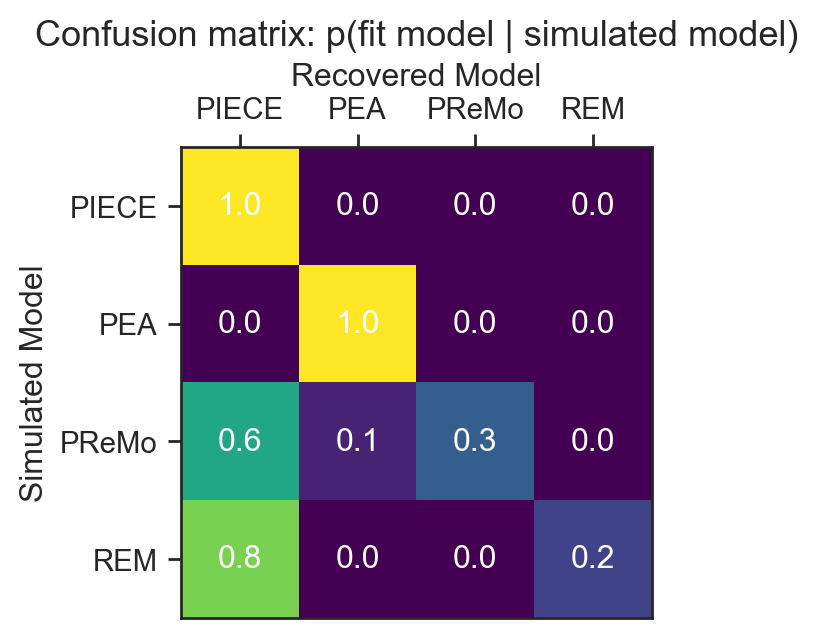

In [5]:
y_true = df_model["model"]
y_pred = df_model["winner_bic"]
df_confusion = pd.crosstab(df_model["model"], df_model["winner_bic"], normalize="index")
df_confusion

def plot_confusion_matrix(df_confusion, title="Confusion matrix: p(fit model | simulated model)"):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    ax.matshow(df_confusion, cmap="viridis") 
    plt.title(title, fontsize=13)
    tick_marks = np.arange(len(df_confusion.columns))
    ax.set_xticks(tick_marks, ["PIECE", "PEA", "PReMo", "REM"])
    ax.xaxis.tick_top()
    ax.set_yticks(tick_marks, ["PIECE", "PEA", "PReMo", "REM"])
    ax.set_ylabel("Simulated Model")
    ax.set_xlabel("Recovered Model")
    ax.xaxis.set_label_position('top')
    # Loop over data dimensions and create text annotations.
    for i in range(len(models)):
        for j in range(len(models)):
            ax.text(j, i, df_confusion.iloc[i, j],
                           ha="center", va="center", color="w")
    plt.tight_layout()

plot_confusion_matrix(df_confusion)

---
## Parameter Recovery Analysis

In [6]:
# Unpack parameters and stack them into 2d arrays
df_simparams = df_model.groupby("model")["simulated_params"].apply(np.stack)
df_fitparams = df_model.groupby("model")["recovered_params"].apply(np.stack)

# Select PIECE parameter matrices
piece_simparams = df_simparams["piece"]
piece_fitparams = df_fitparams["piece"]

# Assign each column to correct parameter
sigma_pert_sim = piece_simparams[:, 0]
sigma_comb_sim = piece_simparams[:, 1]
bias_sim = piece_simparams[:, 2]

sigma_pert_fit = piece_fitparams[:, 0]
sigma_comb_fit = piece_fitparams[:, 1]
bias_fit = piece_fitparams[:, 2]

# Create dataframe
df_piece = pd.DataFrame({"sigma_pert_sim":sigma_pert_sim, 
                         "sigma_comb_sim":sigma_comb_sim, 
                         "bias_sim":bias_sim, 
                         "sigma_pert_fit":sigma_pert_fit,
                         "sigma_comb_fit":sigma_comb_fit,
                         "bias_fit":bias_fit})
df_piece

,sigma_pert_sim,sigma_comb_sim,bias_sim,sigma_pert_fit,sigma_comb_fit,bias_fit
0,4.212943,0.116600,1.077485,3.628779,0.019612,1.054520
1,6.080722,1.119324,1.806642,3.918713,1.489100,1.778953
2,5.826663,1.217682,-0.509045,4.297696,1.786404,-0.458322
3,5.898906,1.278560,-0.645749,3.356671,1.332867,-0.655401
4,3.866317,0.403516,0.823608,3.429261,0.458466,0.800029
5,5.183962,0.876070,1.029619,3.814330,0.019355,0.855556
6,5.712053,0.700659,1.027273,3.619160,0.605092,1.108027
7,3.733278,0.144328,-0.633865,4.996745,0.019990,-0.629454
8,5.752097,0.338423,0.413860,4.954797,1.050524,0.387306
9,6.226471,0.583597,1.731563,4.318330,0.660272,1.829432


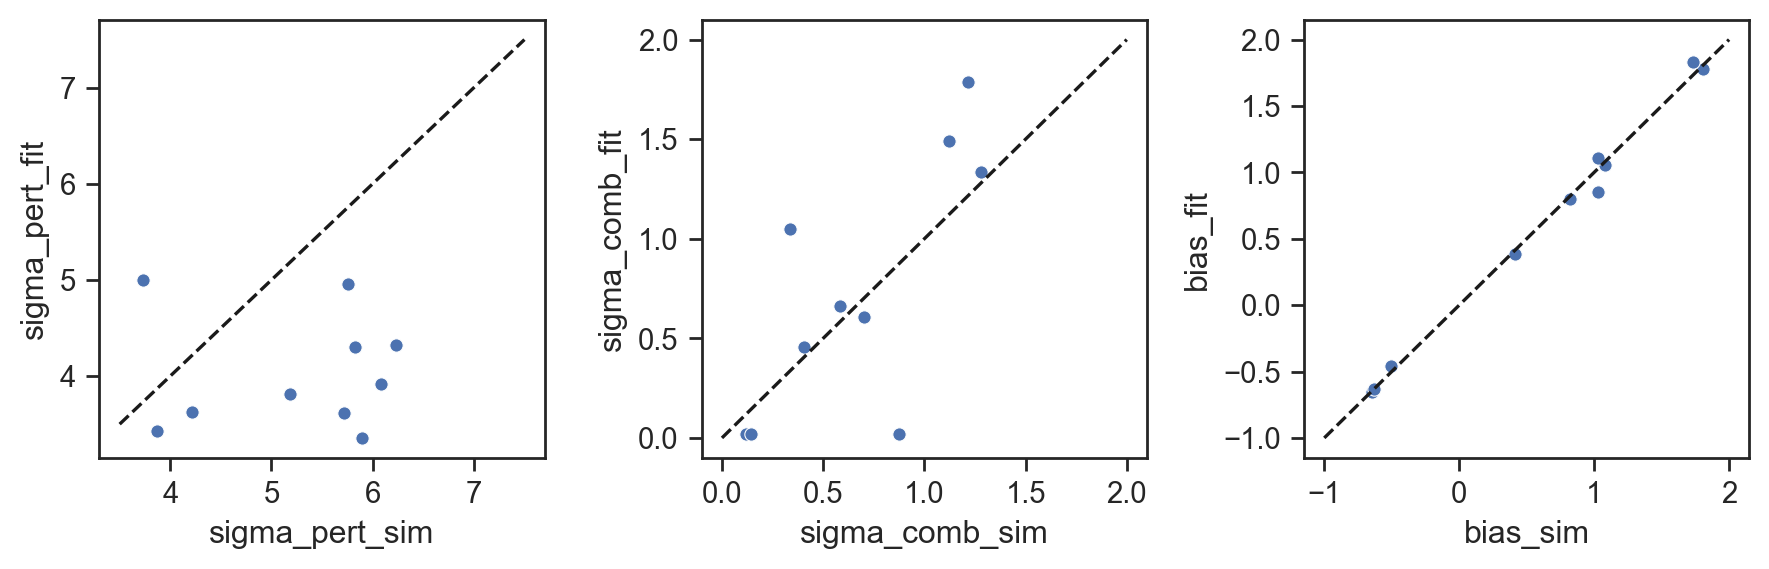

In [8]:
# Plot 3 scatter plots of fit versus simulated parameters
fit, axs = plt.subplots(1, 3, figsize=(9, 3))
sns.scatterplot(data=df_piece, x="sigma_pert_sim", y="sigma_pert_fit", ax=axs[0])
axs[0].plot([3.5, 7.5], [3.5, 7.5], color="k", linestyle="--")
sns.scatterplot(data=df_piece, x="sigma_comb_sim", y="sigma_comb_fit", ax=axs[1])
axs[1].plot([0, 2], [0, 2], color="k", linestyle="--")
sns.scatterplot(data=df_piece, x="bias_sim", y="bias_fit", ax=axs[2])
axs[2].plot([-1, 2], [-1, 2], color="k", linestyle="--")
plt.tight_layout()

In [9]:
r_sigma_pert, p_sigma_pert = sp.stats.pearsonr(
    x=df_piece["sigma_pert_sim"], y=df_piece["sigma_pert_fit"])
r_sigma_comb, p_sigma_comb = sp.stats.pearsonr(
    x=df_piece["sigma_comb_sim"], y=df_piece["sigma_comb_fit"])
print([r_sigma_pert, p_sigma_pert, r_sigma_comb, p_sigma_comb])

[-0.004666760706194428, 0.9897916832805495, 0.7437167623459223, 0.01366647143959121]
